# 🔄 Merged Dataset — Minimal EDA & Preprocessing

This notebook performs a focused quality pass on the merged dataset:
- Quantify and treat missing values with targeted strategies.
- Detect and mitigate outliers using a single, consistent method.
- Apply minimal encoding/scaling and persist a clean artifact for modeling.

Non‑essential analyses (Q–Q plots, correlation matrices, excessive visuals) are intentionally excluded to keep the pipeline lean and reproducible.


# Merging Data

In [1]:
from scripts.dataMerging.combineDatasets import extract_features_elevation , extract_features_landcover , extract_features_monthly_clim , extract_features_soil , organize_monthly_climat_files
from scripts.tools.merge_data_sources import progressive_merge
from scripts.dataMerging.generateGrid import generate_grid_in_shape


## Create a refrence grid


In [2]:

# Step 1: Generate grid (only once)
grid_df = generate_grid_in_shape(
    "../data/shapefiles/combined/alg_tun.shp",
    resolution=0.05, # 5 KM resolution
    output_csv="../data/features/grid_points.csv",
)



📂 Loading shapefile...
🗺️ Bounding box: [-8.67386818 18.96023083 11.98736715 37.55986   ]
📏 Grid: 414 × 372 = 154,008 total points
🔍 Filtering points inside region...
✅ 91,102 points inside shapefile
💾 Saved grid to ../data/features/grid_points.csv


## Extract Nearest Points from grid refrence fire 

In [3]:
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

# Load CSVs
grid = pd.read_csv("../data/features/grid_points.csv")  # longitude, latitude
fire = pd.read_csv("../data/fire_dataset/viirs-jpss1_2024_alg_Tun.csv")  # longitude, latitude, data

# KDTree matching
grid_coords = np.vstack((grid["latitude"],grid["longitude"])).T
fire_coords = np.vstack((fire["latitude"], fire["longitude"])).T

tree = cKDTree(grid_coords)
distances, indices = tree.query(fire_coords, k=1)

# Snap each fire point to its nearest grid cell
fire["grid_lat"] = grid.iloc[indices]["latitude"].values
fire["grid_lon"] = grid.iloc[indices]["longitude"].values

# Choose the fire data column you care about
fire_data_col = "acq_date" 

# Keep only snapped coordinates + fire value
snapped = fire[["grid_lat" , "grid_lon" , fire_data_col]]

# Merge with grid to include all grid cells (NaN where no fire)
merged = pd.merge(
    grid,
    snapped,
    left_on=["latitude" , "longitude"],
    right_on=["grid_lat" , "grid_lon"],
    how="left"
)

# Keep only desired columns
merged = merged[["latitude","longitude",  fire_data_col]]

# Save result
merged.to_csv("../data/features/grid_fire.csv", index=False)
print(f"✅ Saved {merged.shape[0]} grid points with fire data (NaN where no fire)")


✅ Saved 179413 grid points with fire data (NaN where no fire)


## Checking no errors (print fire with new cordonates)

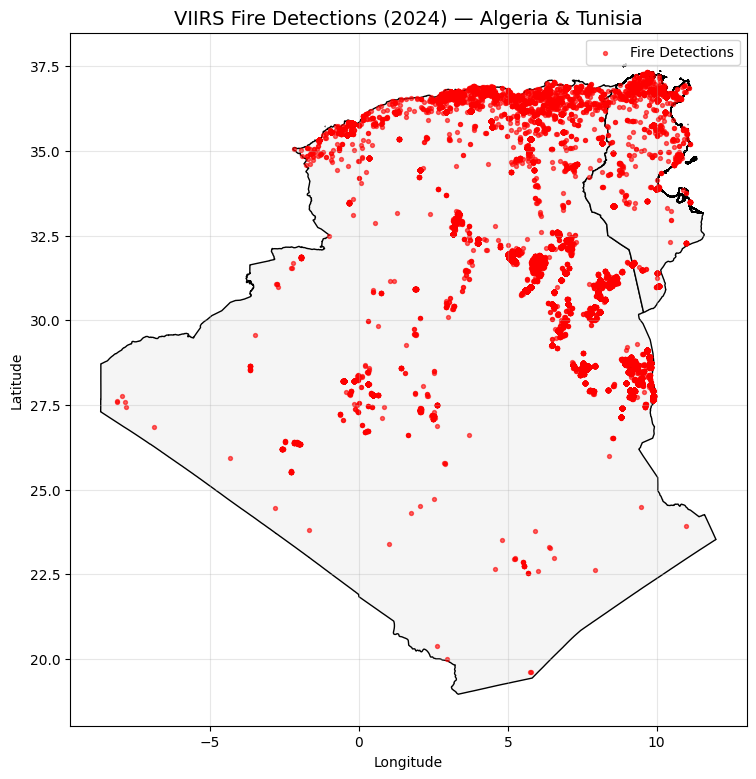

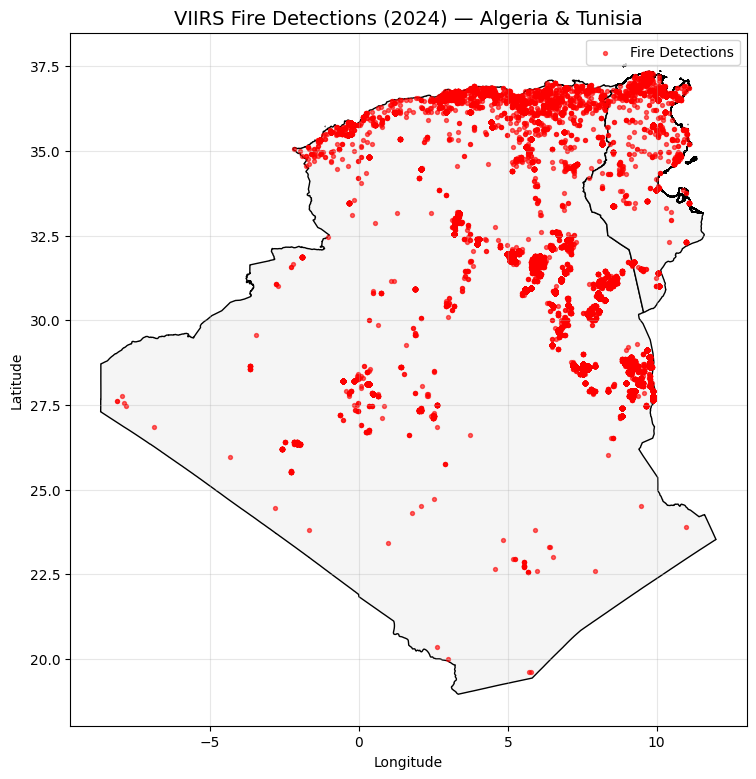

In [4]:
from scripts.plots import plot_fire_map
import geopandas as gpd
from shapely.geometry import Point

#  Load the fire datasets for Algeria and Tunisia ---
fire_alg_tun_path = "../data/fire_dataset/viirs-jpss1_2024_alg_Tun.csv"
alg_tun_shp = gpd.read_file("../data/shapefiles/combined/alg_tun.shp")
fire_df = pd.read_csv(fire_alg_tun_path)


#  Convert fire detections to a GeoDataFrame ---
geometry = [Point(xy) for xy in zip(fire_df["longitude"], fire_df["latitude"])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")  # WGS84

# ORIGINAL _____________________________________________________

# Plot the combined fire detections ---
plot_fire_map(alg_tun_shp, fire_gdf, title="VIIRS Fire Detections (2024) — Algeria & Tunisia")


# New dataset  _____________________________________________________

fire_alg_tun_path = "../data/features/grid_fire.csv"
fire_df = pd.read_csv(fire_alg_tun_path)
fire_df = fire_df.dropna()
geometry = [Point(xy) for xy in zip(fire_df["longitude"], fire_df["latitude"])]
fire_gdf = gpd.GeoDataFrame(fire_df, geometry=geometry, crs="EPSG:4326")  # WGS84
plot_fire_map(alg_tun_shp, fire_gdf, title="VIIRS Fire Detections (2024) — Algeria & Tunisia")





## General function for the preprocessing of all the data

In [2]:
import pandas as pd
import numpy as np

def impute_with_geo_zones(
    df,
    lat_col="latitude",
    lon_col="longitude",
    base_res=0.1,         # initial spatial resolution (degrees)
    min_points=10,        # minimum number of points required
    max_res=5.0,           # upper safety limit for expansion
    output_path ="./dataCleaned.csv"
):

    # --- 1. Compute missing % ---
    missing_percent = df.isnull().mean() * 100
    print("Missing values (percent) per column :")
    print(missing_percent[missing_percent > 0])

    def get_zone_df(lat, lon, res):
        """Return subset of df where points fall inside a lat/lon grid cell."""
        lat_min, lat_max = lat - res, lat + res
        lon_min, lon_max = lon - res, lon + res

        return df[
            (df[lat_col] >= lat_min) & (df[lat_col] <= lat_max) &
            (df[lon_col] >= lon_min) & (df[lon_col] <= lon_max)
        ]

    # --- 2. Process each column ---
    for col in df.columns:
        if missing_percent.get(col, 0) == 0:
            continue
        
        print(f"\n=== Imputing column: {col} ===")
        is_num = pd.api.types.is_numeric_dtype(df[col])

        for idx, row in df[df[col].isnull()].iterrows():
            lat, lon = row[lat_col], row[lon_col]
            resolution = base_res

            zone_df = pd.DataFrame()
            # --- expand resolution until enough points exist ---
            while resolution <= max_res:
                zone_df = get_zone_df(lat, lon, resolution)
                if len(zone_df) >= min_points:
                    break
                resolution *= 1.5  # Increase resolution gradually

            if len(zone_df) == 0:
                # fallback: entire column
                if is_num:
                    replacement = df[col].median()
                else:
                    replacement = df[col].mode(dropna=True).iat[0]
                df.at[idx, col] = replacement
                continue

            # ----- numerical col -----
            if is_num:
                replacement = zone_df[col].median()
                df.at[idx, col] = replacement

            # ----- categorical col -----
            else:
                mode_val = zone_df[col].mode(dropna=True)
                if not mode_val.empty:
                    df.at[idx, col] = mode_val.iat[0]
                else:
                    # fallback global mode (never "Unknown")
                    df.at[idx, col] = df[col].mode(dropna=True).iat[0]

        print(f"{col}: imputation done using geo-zones.")
        if output_path:
            df.to_csv(output_path, index=False)
            print(f"💾 Saved imputation to {output_path}")

    return df


## ☁️ Climat Dataset ☁️



In [6]:

# Organize the files
monthly_tmax_data = organize_monthly_climat_files(
    "../data/climate_dataset/5min/max/*.tif"
)
monthly_tmin_data = organize_monthly_climat_files(
    "../data/climate_dataset/5min/min/*.tif"
)
monthly_tprec_data = organize_monthly_climat_files(
    "../data/climate_dataset/5min/prec/*.tif"
)


fires_tmax = extract_features_monthly_clim(
    point_csv="../data/features/grid_points.csv",
    raster_dict=monthly_tmax_data,
    output_path="../data/features/grid_tmax.csv",
    col_name="tmax",
)


fires_tmin = extract_features_monthly_clim(
    point_csv="../data/features/grid_points.csv",
    raster_dict=monthly_tmin_data,
    output_path="../data/features/grid_tmin.csv",
    col_name="tmin",
)


fires_tprec = extract_features_monthly_clim(
    point_csv="../data/features/grid_points.csv",
    raster_dict=monthly_tprec_data,
    output_path="../data/features/grid_tprec.csv",
    col_name="prec",
)

Month 12: 100%|██████████| 91102/91102 [00:13<00:00, 6936.48it/s]


✅ Finished sampling all monthly rasters.
💾 Saved seasonal climatology to ../data/features/grid_tmax.csv


Month 12: 100%|██████████| 91102/91102 [00:12<00:00, 7566.20it/s]


✅ Finished sampling all monthly rasters.
💾 Saved seasonal climatology to ../data/features/grid_tmin.csv


Month 12: 100%|██████████| 91102/91102 [00:12<00:00, 7389.52it/s]


✅ Finished sampling all monthly rasters.
💾 Saved seasonal climatology to ../data/features/grid_tprec.csv


## General Preprocessing for Climat CSV

In [7]:

tmax_df = pd.read_csv("../data/features/grid_tmax.csv")
tmax_clean = impute_with_geo_zones(tmax_df, base_res=0.05 , min_points=10 ,max_res=0.1, output_path="../data/features_cleaned/grid_tmax_clean.csv")

tmin_df = pd.read_csv("../data/features/grid_tmin.csv")
tmin_clean = impute_with_geo_zones(tmin_df, base_res=0.05, min_points=10 ,max_res=0.1, output_path="../data/features_cleaned/grid_tmin_clean.csv")

tprec_df = pd.read_csv("../data/features/grid_tprec.csv")
tprec_clean = impute_with_geo_zones(tprec_df, base_res=0.05 , min_points=10 ,max_res=0.1, output_path="../data/features_cleaned/grid_prec_clean.csv")


Missing values (percent) per column :
winter_tmax    0.356743
spring_tmax    0.356743
summer_tmax    0.356743
autumn_tmax    0.356743
dtype: float64

=== Imputing column: winter_tmax ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


winter_tmax: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmax_clean.csv

=== Imputing column: spring_tmax ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


spring_tmax: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmax_clean.csv

=== Imputing column: summer_tmax ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


summer_tmax: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmax_clean.csv

=== Imputing column: autumn_tmax ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


autumn_tmax: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmax_clean.csv
Missing values (percent) per column :
winter_tmin    0.356743
spring_tmin    0.356743
summer_tmin    0.356743
autumn_tmin    0.356743
dtype: float64

=== Imputing column: winter_tmin ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


winter_tmin: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmin_clean.csv

=== Imputing column: spring_tmin ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


spring_tmin: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmin_clean.csv

=== Imputing column: summer_tmin ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


summer_tmin: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmin_clean.csv

=== Imputing column: autumn_tmin ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


autumn_tmin: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_tmin_clean.csv
Missing values (percent) per column :
winter_prec    0.356743
spring_prec    0.356743
summer_prec    0.356743
autumn_prec    0.356743
dtype: float64

=== Imputing column: winter_prec ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


winter_prec: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_prec_clean.csv

=== Imputing column: spring_prec ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


spring_prec: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_prec_clean.csv

=== Imputing column: summer_prec ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


summer_prec: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_prec_clean.csv

=== Imputing column: autumn_prec ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


autumn_prec: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_prec_clean.csv


## 🟩 Landcover 🟩

In [8]:

fires_with_landcover = extract_features_landcover(
    csv_path="../data/features/grid_points.csv",
    shapefile_path="../data/land_dataset/combined/alg_tun_landcvr.shp",
    lat_col="latitude",
    lon_col="longitude",
    keep_cols=["GRIDCODE"],  # can be ["GRIDCODE", "CLASS", "AREA", ...]
    output_path="../data/features/grid_landcover.csv",
)


## General Preprocessing for Landcover CSV

In [9]:
landcover_df = pd.read_csv("../data/features/grid_landcover.csv")
landcover_clean = impute_with_geo_zones(landcover_df, base_res=0.05, min_points=10 ,max_res=0.1, output_path="../data/features_cleaned/grid_landcover_clean.csv")


Missing values (percent) per column :
GRIDCODE    0.051591
dtype: float64

=== Imputing column: GRIDCODE ===
GRIDCODE: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_landcover_clean.csv


## 🌱 Soil 🌱

In [10]:
_ , fires_with_soil = extract_features_soil(
    csv_path="../data/features/grid_points.csv",
    raster_path="../data/soil_dataset/original/HWSD2_RASTER/HWSD2.bil",
    soil_attributes_csv="../data/soil_dataset/simplified/D1_soil_features_alg_tun.csv",
    output_soil_ids="../data/features/fire_soil_ids.csv",
    output_soil_feature="../data/features/grid_soil.csv",
)

In [ ]:
import pandas as pd
import numpy as np

def clean_soil_dataset(csv_path,output_path):
    """
    Clean soil dataset by:
      1. Replacing "-" strings with NaN.
      2. If a row contains ANY negative numeric values:
            * delete it if another row exists with same (latitude, longitude)
            * else replace negative values with NaN
    Overwrites the original CSV.
    """

    # Load dataset
    df = pd.read_csv(csv_path)

    # Replace "-" with NaN everywhere
    df = df.replace("-", np.nan)

    # Numeric columns to check for negatives
    numeric_cols = [
        "COARSE","SAND","SILT","CLAY","BULK","REF_BULK","ORG_CARBON",
        "PH_WATER","TOTAL_N","CN_RATIO","CEC_SOIL","CEC_CLAY","CEC_EFF",
        "TEB","BSAT","ALUM_SAT","ESP","TCARBON_EQ","GYPSUM","ELEC_COND"
    ]

    # Convert numeric columns to float (important!)
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Detect rows with at least one negative value
    mask_negative = df[numeric_cols].lt(0).any(axis=1)
    bad_rows = df[mask_negative].copy()

    # Count rows per coordinate
    counts = df.groupby(["latitude", "longitude"]).size()

    rows_to_delete = []
    rows_to_fix = []

    # Process each bad row
    for idx, row in bad_rows.iterrows():
        lat = row["latitude"]
        lon = row["longitude"]

        if counts.loc[(lat, lon)] > 1:
            rows_to_delete.append(idx)
        else:
            rows_to_fix.append(idx)

    # Delete rows entirely
    df_clean = df.drop(rows_to_delete)

    # Replace negative values with NaN in rows to fix
    df_clean.loc[rows_to_fix, numeric_cols] = (
        df_clean.loc[rows_to_fix, numeric_cols]
        .where(df_clean.loc[rows_to_fix, numeric_cols] >= 0, np.nan)
    )

    # Overwrite original CSV
    df_clean.to_csv(output_path, index=False)

    print("✔ Cleaning complete!")
    print(f"  Deleted rows : {len(rows_to_delete)}")
    print(f"  Fixed rows   : {len(rows_to_fix)}")


clean_soil_dataset("../data/features/grid_soil.csv"noutput_path="../data/features_cleaned/grid_soil_clean.csv")

✔ Cleaning complete!
  Deleted rows : 15998
  Fixed rows   : 21237


## General Preprocessing for Soil CSV

In [11]:
soil_df = pd.read_csv("../data/features/grid_soil.csv")

CATEGORICAL_COLS_SOIL = ["TEXTURE_USDA", "TEXTURE_SOTER"]  # categorical columns
NUMERIC_COLS_SOIL = [
    "COARSE", "SAND", "SILT", "CLAY", "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER",
    "TOTAL_N", "CN_RATIO", "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT",
    "ALUM_SAT", "ESP", "TCARBON_EQ", "GYPSUM", "ELEC_COND"
]  # numeric columns

def is_numeric_soil(s, name):
    if name in CATEGORICAL_COLS_SOIL:
        return False
    if name in NUMERIC_COLS_SOIL:
        return True
    return pd.api.types.is_numeric_dtype(s)

def preprocess_soil_data(df):
    print(f"Shape before: {df.shape}")
    print("Columns:", df.columns.tolist())
    display(df.head())

    # Duplicate check on lat/lon and a key numeric column if needed (optional)

    # Missingness
    missing_pct = (df.isnull().mean() * 100).sort_values(ascending=False)
    print("Missing % per column:")
    print(missing_pct[missing_pct > 0])

    # Handle missing values
    for col, pct in missing_pct.items():
        if pct == 0:
            continue
        if is_numeric_soil(df[col], col):
            df[col] = df[col].fillna(df[col].median())
            print(f"{col}: numerical missing filled with median")
        else:
            mode_val = df[col].mode(dropna=True)
            fill_val = mode_val.iat[0] if not mode_val.empty else "Unknown"
            df[col] = df[col].fillna(fill_val)
            print(f"{col}: categorical missing filled with mode or 'Unknown': {fill_val}")

    # # Outlier capping for numeric columns
    # def cap_iqr(s, factor=1.5):
    #     q1, q3 = s.quantile(0.25), s.quantile(0.75)
    #     iqr = q3 - q1
    #     lower, upper = q1 - factor*iqr, q3 + factor*iqr
    #     return s.clip(lower, upper)

    # for col in NUMERIC_COLS_SOIL:
    #     if col in df.columns:
    #         df[col] = cap_iqr(df[col])
    #         print(f"{col}: capped outliers with IQR")

    # Save cleaned soil CSV
    import os
    output_dir = "../data/features_cleaned"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "grid_soil_clean.csv")
    df.to_csv(output_path, index=False)
    print(f"✅ Saved cleaned soil dataset to {output_path}")

    return df

# Usage
soil_cleaned = impute_with_geo_zones(soil_df, base_res=0.05, min_points=10 ,max_res=0.1, output_path="../data/features_cleaned/grid_soil_clean.csv")


Missing values (percent) per column :
COARSE            0.001018
SAND              0.001018
SILT              0.001018
CLAY              0.001018
TEXTURE_USDA     18.959293
TEXTURE_SOTER     0.001018
BULK              0.001018
REF_BULK         18.959293
ORG_CARBON        0.001018
PH_WATER          0.001018
TOTAL_N           0.001018
CN_RATIO          0.001018
CEC_SOIL          0.001018
CEC_CLAY          0.001018
CEC_EFF           0.001018
TEB               0.001018
BSAT              0.001018
ALUM_SAT          0.001018
ESP               0.001018
TCARBON_EQ        0.001018
GYPSUM            0.001018
ELEC_COND         0.001018
dtype: float64

=== Imputing column: COARSE ===
COARSE: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: SAND ===
SAND: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: SILT ===
SILT: imputation done using geo-zones.
💾 Sav

d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out

TEXTURE_USDA: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: TEXTURE_SOTER ===
TEXTURE_SOTER: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: BULK ===
BULK: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: REF_BULK ===


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out

REF_BULK: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: ORG_CARBON ===
ORG_CARBON: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: PH_WATER ===
PH_WATER: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: TOTAL_N ===
TOTAL_N: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: CN_RATIO ===
CN_RATIO: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: CEC_SOIL ===
CEC_SOIL: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing column: CEC_CLAY ===
CEC_CLAY: imputation done using geo-zones.
💾 Saved imputation to ../data/features_cleaned/grid_soil_clean.csv

=== Imputing colu

## 🏔️ Elevation 🏔️

In [12]:
fires_with_elevation = extract_features_elevation(
    raster_path="../data/elevation_dataset/simplified/elevation_clipped.tif",
    fire_csv_path="../data/features/grid_points.csv",
    output_csv="../data/features/grid_elevation.csv",
    value_name="elevation",
)


Loaded 91102 points from ../data/features/grid_points.csv


Extracting elevation: 100%|██████████| 91102/91102 [00:13<00:00, 6933.98it/s]


✅ Saved extracted elevation to ../data/features/grid_elevation.csv


## General Preprocessing for Elevation CSV

In [13]:
elevation_df = pd.read_csv("../data/features/grid_elevation.csv")
elevation_df_cleaned = impute_with_geo_zones(elevation_df, base_res=0.05, min_points=10 ,max_res=0.1, output_path="../data/features_cleaned/grid_elevation_clean.csv")


Missing values (percent) per column :
Series([], dtype: float64)


#  🔥Fire 🔥

In [14]:
import pandas as pd

# Load your CSV
df_fire = pd.read_csv("../data/features/grid_fire.csv")

# Create 'fire' column: 1 if acq_date exists, 0 if missing
df_fire["fire"] = df_fire["acq_date"].notna().astype(int)

# Keep only latitude, longitude, and fire
df_fire = df_fire[["latitude", "longitude", "fire"]]

# ✅ Identify duplicate (lat, lon) groups
duplicates = df_fire[df_fire.duplicated(subset=["latitude", "longitude"], keep=False)]

if duplicates.empty:
    print("✅ No duplicate (latitude, longitude) found.")
else:
    print(f"⚠️ Found {len(duplicates)} duplicate rows.")

    # Group by coordinate pairs and check fire values
    fire_stats = (
        duplicates.groupby(["latitude", "longitude"])["fire"]
        .apply(lambda x: list(x))
        .reset_index(name="fire_values")
    )

    # Case 1 — All fire = 1
    all_fire_1 = fire_stats[fire_stats["fire_values"].apply(lambda x: all(v == 1 for v in x))]
    if not all_fire_1.empty:
        print(f"🔥 Duplicates where all fire=1: {len(all_fire_1)}")
        print(all_fire_1.head())
    else:
        print("✅ No duplicates where all fire=1")

    # Case 2 — At least one fire=0
    some_fire_0 = fire_stats[fire_stats["fire_values"].apply(lambda x: any(v == 0 for v in x))]
    if not some_fire_0.empty:
        print(f"🚨 Duplicates where at least one fire=0: {len(some_fire_0)}")
        print(some_fire_0.head())
    else:
        print("✅ No duplicates where any fire=0")

# ✅ Remove duplicates, keep one (prefer fire=1)
df_fire = (
    df_fire.sort_values("fire", ascending=False)
    .drop_duplicates(subset=["latitude", "longitude"], keep="first")
)

# ✅ Save cleaned version
df_fire.to_csv("../data/features/grid_fire.csv", index=False)
print(f"💾 Cleaned file saved — now {len(df_fire)} unique (lat, lon) pairs.")


⚠️ Found 89391 duplicate rows.
🔥 Duplicates where all fire=1: 1080
    latitude  longitude         fire_values
0  22.560231   5.676132        [1, 1, 1, 1]
1  22.710231   5.526132           [1, 1, 1]
2  22.760231   5.526132  [1, 1, 1, 1, 1, 1]
3  22.860231   5.526132        [1, 1, 1, 1]
4  22.960231   5.226132              [1, 1]
✅ No duplicates where any fire=0
💾 Cleaned file saved — now 91102 unique (lat, lon) pairs.


In [15]:
fire_clean = pd.read_csv("../data/features/grid_fire.csv")


# Merge

In [16]:
import os
import gc  # garbage collector

def safe_merge(csv_list, on=["latitude", "longitude"], how="inner", output_path=None, chunksize=500000):
    """
    Merge multiple CSVs efficiently on given keys (latitude, longitude).
    Handles memory issues by ensuring unique keys and using incremental merging.
    """
    
    print("🧩 Starting merge process...")
    
    # Step 1 — Load first CSV
    base_path = csv_list[0]
    print(f"Loading base file: {base_path}")
    merged_df = pd.read_csv(base_path)
    print(f"Shape: {merged_df.shape}")
    
    # Step 2 — Ensure keys exist
    for col in on:
        if col not in merged_df.columns:
            raise ValueError(f"Column '{col}' not found in {base_path}")
    
    # Step 3 — Iterative merging
    for path in csv_list[1:]:
        print(f"\n🔗 Merging with: {path}")
        df = pd.read_csv(path)
        print(f"  -> Loaded shape: {df.shape}")

        # Sanity check for key columns
        for col in on:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in {path}")

        # Drop duplicates on keys to avoid cartesian explosion
        before = len(df)
        df = df.drop_duplicates(subset=on)
        print(f"  -> Dropped {before - len(df)} duplicates on merge keys.")

        # Merge (use inner to keep only common points)
        merged_df = pd.merge(merged_df, df, on=on, how=how)
        print(f"✅ Merged shape: {merged_df.shape}")

        # Memory cleanup
        del df
        gc.collect()

        # Optional safety checkpoint
        if output_path:
            temp_path = output_path.replace(".csv", "_partial.csv")
            merged_df.to_csv(temp_path, index=False)
            print(f"💾 Partial save: {temp_path}")

    # Step 4 — Final save
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        merged_df.to_csv(output_path, index=False)
        print(f"\n✅ Final merged dataset saved to: {output_path}")

    return merged_df


## 🔥 Merging with Fire Data 🔥

In [17]:
csv_list= ["../data/features_cleaned/grid_tmax_clean.csv", "../data/features_cleaned/grid_tmin_clean.csv","../data/features_cleaned/grid_tprec_clean.csv",  "../data/features_cleaned/grid_landcover_clean.csv" , "../data/features_cleaned/grid_elevation_clean.csv" , "../data/features_cleaned/grid_soil_clean.csv","../data/features_cleaned/grid_fire_clean.csv"]
temp_df = progressive_merge(
    csv_list,
    on=["latitude", "longitude"],
    how="inner",
    output_path="../data/Merged/merged.csv"
)


Loading first CSV: ../data/features_cleaned/grid_tmax_clean.csv
🔁 Merging file 2/7: ../data/features_cleaned/grid_tmin_clean.csv
✅ Intermediate merged size: (91102, 10)
🔁 Merging file 3/7: ../data/features_cleaned/grid_tprec_clean.csv
✅ Intermediate merged size: (91102, 11)
🔁 Merging file 4/7: ../data/features_cleaned/grid_landcover_clean.csv
✅ Intermediate merged size: (91102, 12)
🔁 Merging file 5/7: ../data/features_cleaned/grid_elevation_clean.csv
✅ Intermediate merged size: (91102, 13)
🔁 Merging file 6/7: ../data/features_cleaned/grid_soil_clean.csv
✅ Intermediate merged size: (196405, 35)
🔁 Merging file 7/7: ../data/features_cleaned/grid_fire_clean.csv
✅ Intermediate merged size: (196405, 36)
✅ All files merged successfully.
